In [2]:
!pip -q install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.2 MB/s eta 0:00:00


In [3]:
!pip -q install nltk

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

import re
import nltk
nltk.download('stopwords')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

import random
from joblib import dump

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data = pd.read_excel('dataset_mobil_listrik.xlsx')
data.head()

,text,label
0,Mulai tertarik mobil listrik,Positive
1,Dagang kok recehan anak presiden buat pabrik m...,Negative
2,Kalo kosan/rumah lu bisa ngecharge mobil listr...,Positive
3,Gw curiga kalo nanti mobil/motor listrik meraj...,Negative
4,karena mobil listrik ratarata single transmiss...,Negative


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    683 non-null    object
 1   label   683 non-null    object
dtypes: object(2)
memory usage: 10.8+ KB


## Exploratory Data Analysis (EDA)

In [16]:
print('Total Jumlah SMS:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- Positive\t:', data[data.label == 'Positive'].shape[0], 'data')
print('-- Negative\t:', data[data.label == 'Negative'].shape[0], 'data')

Total Jumlah SMS: 683 data

terdiri dari (label):
-- Positive	: 286 data
-- Negative	: 397 data


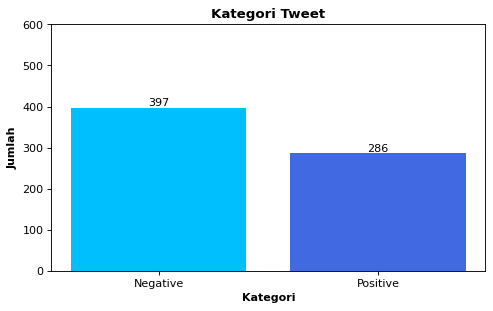

In [14]:
height = data['label'].value_counts()
labels = ('Negative','Positive')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7, 4), dpi=80)
plt.ylim(0, 600)
plt.title('Kategori Tweet', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
bars = plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)

# Menambahkan angka di atas setiap batang
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), height[i],
             ha='center', va='bottom', color='black')

plt.show()

## Text Preprocessing

### Case Folding

In [ ]:
# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [ ]:
raw_sample   = data['text'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  kalo mmg udah disita knp ngaku beban anggaran kalo mmg Esemka nya uda banyak yg pakai knp mau ganti mobil listrik knp gak pakai esemka aja
Case folding	:  kalo mmg udah disita knp ngaku beban anggaran kalo mmg esemka nya uda banyak yg pakai knp mau ganti mobil listrik knp gak pakai esemka aja


### Word Normalization

In [ ]:
key_norm = pd.read_csv('key_norm.csv')

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

### Filtering (Stopword Removal)

In [ ]:
stopwords_ind = stopwords.words('indonesian')

In [ ]:
len(stopwords_ind)

758

In [ ]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [ ]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['donk', 'nya', 'wkwkwk','hhhhh','hahaha','hahah']               # Tambahkan kata dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [ ]:
raw_sample       = data['text'].iloc[5]
case_folding     = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  kalo mmg udah disita knp ngaku beban anggaran kalo mmg Esemka nya uda banyak yg pakai knp mau ganti mobil listrik knp gak pakai esemka aja
Case folding		:  kalo mmg udah disita knp ngaku beban anggaran kalo mmg esemka nya uda banyak yg pakai knp mau ganti mobil listrik knp gak pakai esemka aja
Stopword removal	:  kalo mmg udah disita knp ngaku beban anggaran kalo mmg esemka uda yg pakai knp ganti mobil listrik knp gak pakai esemka aja


### Stemming

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [ ]:
raw_sample       = data['text'].iloc[5]
case_folding     = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming    = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  kalo mmg udah disita knp ngaku beban anggaran kalo mmg Esemka nya uda banyak yg pakai knp mau ganti mobil listrik knp gak pakai esemka aja
Case folding		:  kalo mmg udah disita knp ngaku beban anggaran kalo mmg esemka nya uda banyak yg pakai knp mau ganti mobil listrik knp gak pakai esemka aja
Stopword removal	:  kalo mmg udah disita knp ngaku beban anggaran kalo mmg esemka uda yg pakai knp ganti mobil listrik knp gak pakai esemka aja
Stemming		:  kalo mmg udah sita knp ngaku beban anggar kalo mmg esemka uda yg pakai knp ganti mobil listrik knp gak pakai esemka aja


### Text Preprocessing Pipeline

In [ ]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [ ]:
%%time
data['clean_teks'] = data['text'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 1min 55s, sys: 395 ms, total: 1min 55s
Wall time: 2min 2s


In [ ]:
data

,text,label,clean_teks
0,Mulai tertarik mobil listrik,Positive,tarik mobil listrik
1,Dagang kok recehan anak presiden buat pabrik m...,Negative,dagang receh anak presiden pabrik mobil listri...
2,Kalo kosan/rumah lu bisa ngecharge mobil listr...,Positive,kosanrumah ngecharge mobil listrik ya pilih ai...
3,Gw curiga kalo nanti mobil/motor listrik meraj...,Negative,curiga mobilmotor listrik merajalele suara bis...
4,karena mobil listrik ratarata single transmiss...,Negative,mobil listrik ratarata single transmission ema...
...,...,...,...
678,Mobil juga kita kasih subsidi karena dia tidak...,Positive,mobil kasih subsidi beli bensin untung sepeda ...
679,Buat mobil konvensional aja lom sempurna,Negative,mobil konvensional sempurna
680,Mobil listrik membuat rakyat sengsara,Negative,mobil listrik rakyat sengsara
681,Mobil Listrik Esemka Diusulkan Dapat Subsidi d...,Positive,mobil listrik esemka usul subsidi perintah kas...


In [ ]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

## Feature Engineering

In [ ]:
# Pisahkan kolom feature dan target
X = data['clean_teks']
y = data['label']

In [ ]:
X

0                                    tarik mobil listrik
1      dagang receh anak presiden pabrik mobil listri...
2      kosanrumah ngecharge mobil listrik ya pilih ai...
3      curiga mobilmotor listrik merajalele suara bis...
4      mobil listrik ratarata single transmission ema...
                             ...                        
678    mobil kasih subsidi beli bensin untung sepeda ...
679                          mobil konvensional sempurna
680                        mobil listrik rakyat sengsara
681    mobil listrik esemka usul subsidi perintah kas...
682                                 tiati om penjara lho
Name: clean_teks, Length: 683, dtype: object

In [ ]:
y

0      Positive
1      Negative
2      Positive
3      Negative
4      Negative
         ...   
678    Positive
679    Negative
680    Negative
681    Positive
682    Negative
Name: label, Length: 683, dtype: object

### Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [ ]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

2428


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['absurd' 'abugosokkk' 'abun' ... 'zero' 'zerro' 'zoom']


In [ ]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,absurd,abugosokkk,abun,ac,acakadut,acar,acara,ada,adil,adopsi,...,yogyakarta,yransportasi,yuk,yutub,yv,zaman,zenix,zero,zerro,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

### Feature Selection

In [ ]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [ ]:
# Ten features with highest chi-squared statistics are selected 
chi2_features    = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 2428
Reduced feature number: 1000


In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.169468
1,0.160743
2,0.156861
3,0.203903
4,0.169468
...,...
2423,0.896181
2424,0.330264
2425,0.249158
2426,0.820764


In [ ]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.169468,absurd
1,0.160743,abugosokkk
2,0.156861,abun
3,0.203903,ac
4,0.169468,acakadut
...,...,...
2423,0.896181,zaman
2424,0.330264,zenix
2425,0.249158,zero
2426,0.820764,zerro


In [ ]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
1047,6.003989e+00,keren
622,4.966749e+00,ev
605,4.297365e+00,enak
2396,4.119664e+00,wow
194,3.879595e+00,banget
...,...,...
176,1.970289e-05,bakar
1408,6.119569e-06,mobilitas
89,5.323978e-06,angkat
392,5.120331e-07,capek


In [ ]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False, False, ..., False,  True, False])

In [ ]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['acara',
 'ada',
 'ae',
 'afghanistan',
 'ahmad',
 'ai',
 'air',
 'airev',
 'ajak',
 'ajamantaaap',
 'ajg',
 'aju',
 'akal',
 'akalmereka',
 'akan',
 'aktivitas',
 'ala',
 'alah',
 'alay',
 'alesan',
 'alien',
 'all',
 'alternatif',
 'alun',
 'alus',
 'ambil',
 'amerika',
 'amphibi',
 'ampun',
 'anak',
 'andelkan',
 'angeles',
 'anggur',
 'angka',
 'anis',
 'anjuenk',
 'anter',
 'antri',
 'anying',
 'aparat',
 'apbd',
 'aplg',
 'apple',
 'arab',
 'arah',
 'area',
 'artikel',
 'asal',
 'asia',
 'asik',
 'aspirasi',
 'astute',
 'atas',
 'ato',
 'atur',
 'australia',
 'auto',
 'autonomous',
 'avanza',
 'awal',
 'awards',
 'aware',
 'ayo',
 'ba',
 'baca',
 'bae',
 'bagus',
 'bahasa',
 'baik',
 'bal',
 'balas',
 'balik',
 'ban',
 'bandar',
 'banderol',
 'banding',
 'bandingin',
 'bandung',
 'bangeettt',
 'banget',
 'bangett',
 'bangettt',
 'bangettttt',
 'bangga',
 'bangke',
 'bangkit',
 'bangsa',
 'bangun',
 'banjir',
 'banyak',
 'bara',
 'baru',
 'barusan',
 'baterai',
 'bates',
 'batinm

In [ ]:
# Memilih fitur yang telah terseleksi dari vocabulary TF IDF
kbest_feature = {}

for (k,v) in tf_idf.vocabulary_.items():
  if k in selected_feature:
    kbest_feature[k] = v

In [ ]:
len(kbest_feature)

1000

In [ ]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,acara,ada,ae,afghanistan,ahmad,ai,air,airev,ajak,ajamantaaap,...,xixi,xpander,yaeyalah,yah,yaiyalah,yak,yakkk,yarobun,zaman,zerro
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.243309,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
679,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
680,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

## Modelling (Machine Learning)

In [ ]:
# Memisihkan data training dan data testing dengan perbandingan 80:20
X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.svm import LinearSVC

# Membuat objek SVM dengan kernel linier
algorithm = LinearSVC()

# Melatih model dengan data pelatihan
model = algorithm.fit(X_train, y_train)

## Prediction

In [ ]:
# Prediksi untuk Data Latih
predicted_train = model.predict(X_train)

# hasil ini akan kita bandingkan dengan nilai y_train (labeling dari manusia)
predicted_train[1:20]

array(['Negative', 'Positive', 'Positive', 'Negative', 'Negative',
       'Negative', 'Negative', 'Positive', 'Positive', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Positive', 'Negative', 'Positive'], dtype=object)

In [ ]:
# Prediksi untuk Data Uji
predicted_test = model.predict(X_test)

# hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted_test[1:20]

array(['Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Positive', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Positive', 'Positive', 'Positive'], dtype=object)

# Model Evaluation

In [ ]:
# Perhitungan Performa Model untuk Data Latih
CM = confusion_matrix(y_train, predicted_train)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_train, predicted_train)*100,"%\n")

print(classification_report(y_train,predicted_train))

[[314   2]
 [  9 221]] 

ACCURACY	: 97.98534798534799 %

              precision    recall  f1-score   support

    Negative       0.97      0.99      0.98       316
    Positive       0.99      0.96      0.98       230

    accuracy                           0.98       546
   macro avg       0.98      0.98      0.98       546
weighted avg       0.98      0.98      0.98       546



In [ ]:
# Perhitungan Performa Model untuk Data Uji
CM = confusion_matrix(y_test, predicted_test)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_test, predicted_test)*100,"%\n")

print(classification_report(y_test,predicted_test))

[[75  6]
 [19 37]] 

ACCURACY	: 81.75182481751825 %

              precision    recall  f1-score   support

    Negative       0.80      0.93      0.86        81
    Positive       0.86      0.66      0.75        56

    accuracy                           0.82       137
   macro avg       0.83      0.79      0.80       137
weighted avg       0.82      0.82      0.81       137



## Menyimpan Model

In [ ]:
# save the model to disk
dump(model, filename="model.model")

['model.model']